In [11]:
import os
import glob
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [12]:
print(tf.__version__)
print(tf.keras.__version__)
print("TensorFlow version:", tf.__version__)

2.11.0
2.11.0
TensorFlow version: 2.11.0


In [13]:
# Set some parameters
im_width = 256
im_height =256
border = 5

In [14]:
dataset_path = "dataset path"
files = os.listdir(dataset_path)
print(files)

['BI', 'RES']


In [15]:
def count_images_in_directory(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_count = 0

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_extension = os.path.splitext(file)[1].lower()
            if any(file_extension == ext or file_extension == ext.upper() for ext in image_extensions):
                image_count += 1

    return image_count

In [16]:
# Count the total number of images in the dataset
total_images = count_images_in_directory(dataset_path)

print("No. of images = ", total_images)

No. of images =  16800


In [17]:
masks="masks path"
ms = os.listdir(masks)
print(ms)

['BI', 'RES']


In [18]:
d = glob.glob(os.path.join(dataset_path, '**', '*.[jJp][pPn][gGg]'), recursive=True)
m= glob.glob(os.path.join(masks, '**', '*.jpg'), recursive=True)

In [19]:
X = np.zeros((len(m), im_height, im_width, 3), dtype=np.float32)  # creating two NumPy arrays, X and y
y = np.zeros((len(m), im_height, im_width, 1), dtype=np.float32)  #The shape of the array is determined by (len(ids), im_height, im_width, 1)
len(X)


731

In [20]:
# Arrays to store images and masks
for n, id_ in tqdm_notebook(enumerate(m), total=len(m)):
  #if n==5:
    #break;
  img_path = id_.replace('ISPFDv2 masks', 'ISPFDv2 dataset')
  if os.path.exists(img_path):
      #print(img_path)

      img = load_img(img_path, color_mode="rgb")
      x_img = img_to_array(img)
      x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)
      

  else:
      root, ext = img_path.split('.')
      img_upper = root + '.' + f"{ext.upper()}"
      # print(img_upper)
      img = load_img(img_upper, color_mode="rgb")
      x_img = img_to_array(img)
      x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)
      
      
    # Modify mask path to consider the directory structure
  mask_path = os.path.join(dataset_path, id_)

  mask = load_img(mask_path, grayscale=True)
  #mask = load_img(masks +id_, grayscale=True)
  m_mask = img_to_array(mask)
  m_mask = resize(m_mask, (256, 256, 1), mode='constant', preserve_range=True)

  # Save images
  X[n] = x_img / 255.0 
  y[n] = m_mask / 255.0
  y[n]= (y[n]>0.01).astype(np.uint8)

  X = np.array(X)
  y = np.array(y)
  




/tmp/ipykernel_10943/2968619172.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(m), total=len(m)):


/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


values: 1.0


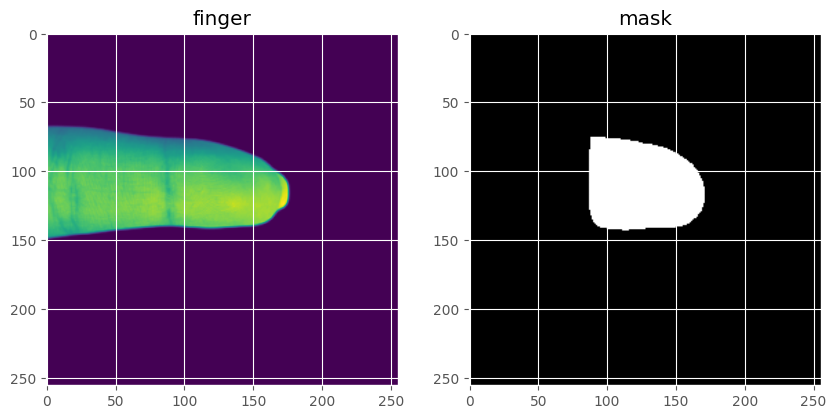

In [25]:

# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
#ix=1
has_mask = y_train[ix].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.imshow(X_train[ix, ..., 0], cmap = None, interpolation = 'bilinear')
#if has_mask:
   # ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('finger')

ax2.imshow(y_train[ix], cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('mask')
# print("values:", np.unique(y_train[ix]))
print("values:", np.max(y_train[ix]))


In [26]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #brightness_range=[0.5, 1.5],  # Adjust the brightness
    fill_mode='nearest'
)

# Arrays to store augmented images and masks
X_augmented = np.zeros_like(X)
y_augmented = np.zeros_like(y)

# Apply data augmentation
for n, (x_img, m_mask) in tqdm_notebook(enumerate(zip(X, y)), total=len(X)):
    seed = np.random.randint(1, 1000)

    # Image augmentation
    x_img_augmented = datagen.random_transform(x_img, seed=seed)
    x_img_augmented = datagen.standardize(x_img_augmented)

    # Mask augmentation
    m_mask_augmented = datagen.random_transform(m_mask, seed=seed)

    # Save augmented images
    X_augmented[n] = x_img_augmented
    y_augmented[n] = m_mask_augmented

# Concatenate original and augmented data
X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)

# Split combined data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Print the length of training and validation sets
print(len(X_train))
print(len(y_train))

/tmp/ipykernel_10943/2555491309.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, (x_img, m_mask) in tqdm_notebook(enumerate(zip(X, y)), total=len(X)):



1169
1169


In [27]:
print("values:", np.unique(y_train))

values: [0.0000000e+00 4.5720978e-07 1.4878133e-06 ... 9.9999750e-01 9.9999857e-01
 1.0000000e+00]


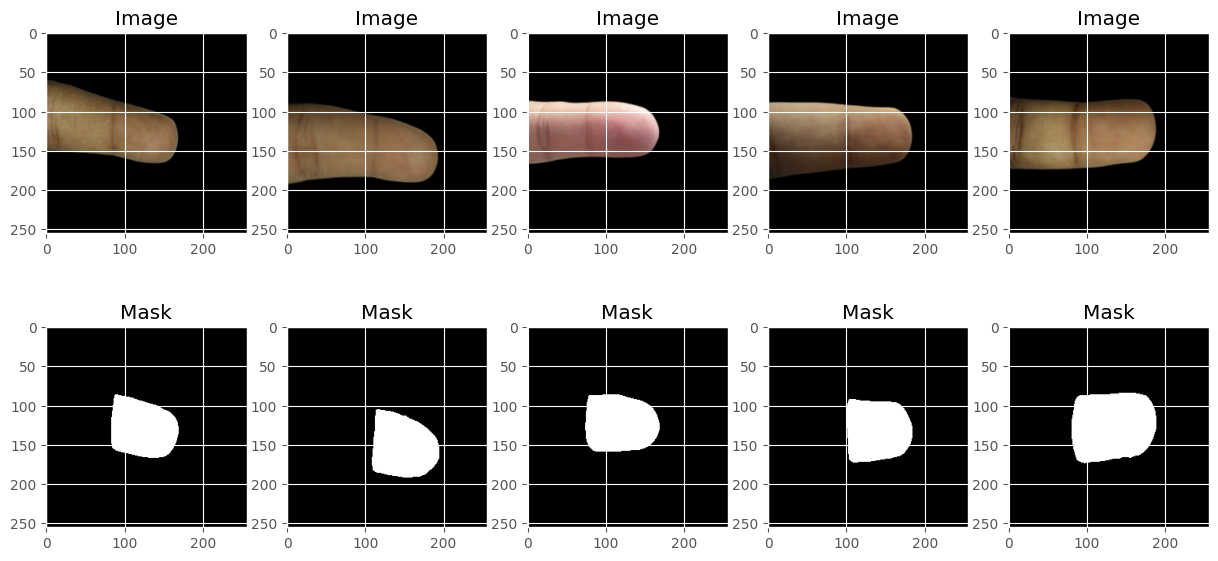

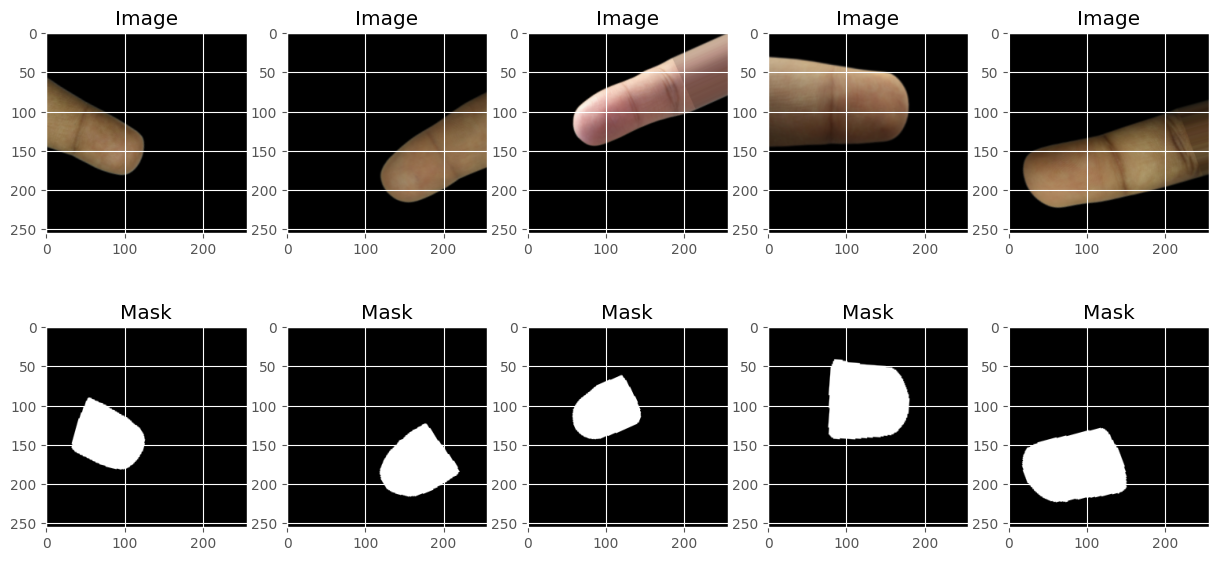

In [29]:
# Function to display images and masks
def display_images(images, masks, num_samples=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title('Image')

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask')
    plt.show()

# Display original and augmented images
display_images(X[:5], y[:5], num_samples=5)
display_images(X_augmented[:5], y_augmented[:5], num_samples=5)

In [32]:
from scipy.ndimage import gaussian_filter
X_valid_b= np.copy(X_valid)
for i in range(len(X_valid)):
    X_valid[i] = gaussian_filter(X_valid[i], sigma=1.2)  # You can adjust the sigma parameter based on the amount of blur you want.

# Verify the shape of X_valid after adding blur
print(X_valid.shape)


(293, 256, 256, 3)


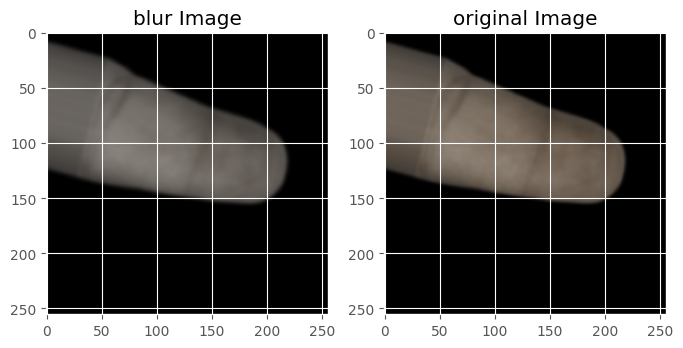

In [37]:
import matplotlib.pyplot as plt
#X_valid_blurred = np.copy(X_valid)


# Choose an index for visualization
index_to_visualize = 4

# Visualize original and blurred test images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_valid[index_to_visualize])
plt.title('blur Image')
plt.axis('ON')

plt.subplot(1, 2, 2)
plt.imshow(X_valid_b[index_to_visualize])
plt.title('original Image')
plt.axis('ON')

plt.show()

In [46]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [47]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100


2024-02-21 11:44:21.169780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-21 11:44:22.371960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-02-21 11:44:23.027739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-21 11:44:23.524578: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1dfe84c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 11:44:23.524596: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-02-21 11:44:23.527672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabl

37/37 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.8439
Epoch 1: val_loss improved from inf to 1.47865, saving model to model.h5
37/37 [==============================] - 27s 349ms/step - loss: 0.5152 - accuracy: 0.8439 - val_loss: 1.4786 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.9351
Epoch 2: val_loss improved from 1.47865 to 0.38459, saving model to model.h5
37/37 [==============================] - 10s 284ms/step - loss: 0.2967 - accuracy: 0.9351 - val_loss: 0.3846 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9640
Epoch 3: val_loss improved from 0.38459 to 0.30584, saving model to model.h5
37/37 [==============================] - 11s 294ms/step - loss: 0.1935 - accuracy: 0.9640 - val_loss: 0.3058 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - ETA: 0s - lo

In [48]:
print(np.unique(y_train))

[0.0000000e+00 4.5720978e-07 1.4878133e-06 ... 9.9999750e-01 9.9999857e-01
 1.0000000e+00]


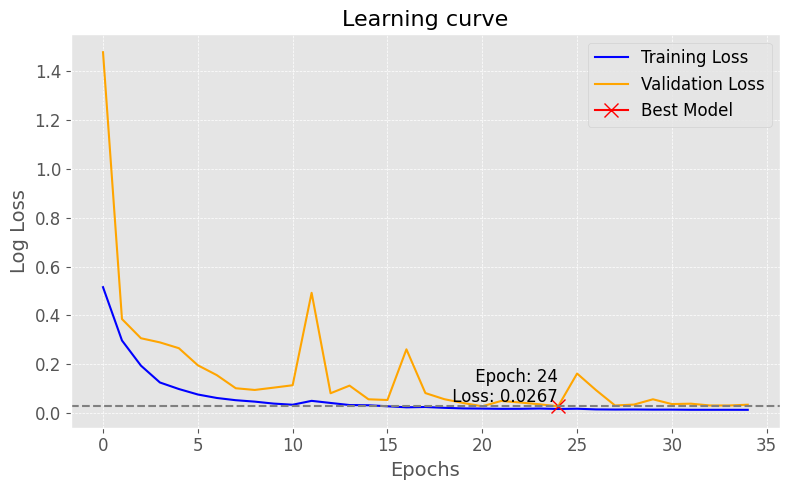

In [49]:
plt.figure(figsize=(8, 5))
plt.title("Learning curve", fontsize=16)
plt.plot(results.history["loss"], label="Training Loss", color="blue")
plt.plot(results.history["val_loss"], label="Validation Loss", color="orange")
best_epoch = np.argmin(results.history["val_loss"])
plt.plot(best_epoch, np.min(results.history["val_loss"]), marker="x", color="red", markersize=10, label="Best Model")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(y=np.min(results.history["val_loss"]), color="gray", linestyle="--")
plt.text(best_epoch, np.min(results.history["val_loss"]), f' Epoch: {best_epoch}\n Loss: {np.min(results.history["val_loss"]):.4f}', fontsize=12, ha='right', va='bottom')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [50]:
# load the best model
#model.load_weights('/content/drive/MyDrive/model.h5')
model.load_weights('model.h5')


In [51]:
#import tensorflow as tf
#model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5')

In [52]:
# Evaluate on test set
model.evaluate(X_valid, y_valid, verbose=1)


10/10 [==============================] - 1s 58ms/step - loss: 0.0267 - accuracy: 0.9895


[0.02665242739021778, 0.9895396828651428]

In [54]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
print("Raw Predictions:", preds_train.min(), preds_train.max())

10/10 [==============================] - 0s 51ms/step
Raw Predictions: 0.0008312628 0.9999999


In [68]:
#print(iou)

In [56]:
# Threshold predictions

threshold=0.5
preds_train_t =(preds_train > threshold).astype(np.uint8)
preds_val_t =(preds_val > threshold).astype(np.uint8)
print(preds_train_t.shape)
print(preds_val_t.shape)
print("Shape of preds_train_t:", preds_train_t.shape)
print("Unique Values in preds_train_t:", np.unique(preds_train_t))
#print("Thresholded Mask:", preds_train_t[i, ..., 0])

(1169, 256, 256, 1)
(293, 256, 256, 1)
Shape of preds_train_t: (1169, 256, 256, 1)
Unique Values in preds_train_t: [0 1]


In [57]:
def calculate_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum((y_true + y_pred) > 0)
    iou = intersection / union if union > 0 else 0.0
    return iou
iou_train = calculate_iou(y_train.reshape(-1), preds_train_t.reshape(-1))
iou_valid = calculate_iou(y_valid.reshape(-1), preds_val_t.reshape(-1))

print(f'IoU on train set: {iou_train}')
print(f'IoU on validation set: {iou_valid}')

IoU on train set: 0.9384668005416086
IoU on validation set: 0.8967166363749491


In [63]:
def plot_sample(X, y, preds, binary_preds, ix=None, train_loss=None, val_loss=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    iou = calculate_iou(y[ix].reshape(-1), binary_preds[ix].reshape(-1))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.3])
    ax[0].set_title('Fingerphoto')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground-truth Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Mask with IoU')

    # Calculate IoU for the current sample
    #iou = calculate_iou(y[ix].reshape(-1), preds[ix].reshape(-1))
    
    # Add IoU text to the plot
    ax[2].text(0.5, 0.95, f'IoU: {iou:.2f}', color='white', backgroundcolor='black',
               transform=ax[2].transAxes, ha='center', fontsize=11)
    
    # Add training and validation loss text to the plot
    ax[2].text(0.5, 0.95, f'IoU: {iou:.2f}', color='white', backgroundcolor='black',
           transform=ax[2].transAxes, ha='center', fontsize=12)

# Add training and validation loss text to the plot
    if train_loss is not None and val_loss is not None:
        ax[2].text(0.5, 0.75, f'Train Loss: {train_loss:.4f}\nVal Loss: {val_loss:.4f}',
               color='white', backgroundcolor='black', transform=ax[2].transAxes,
               ha='center', fontsize=12)

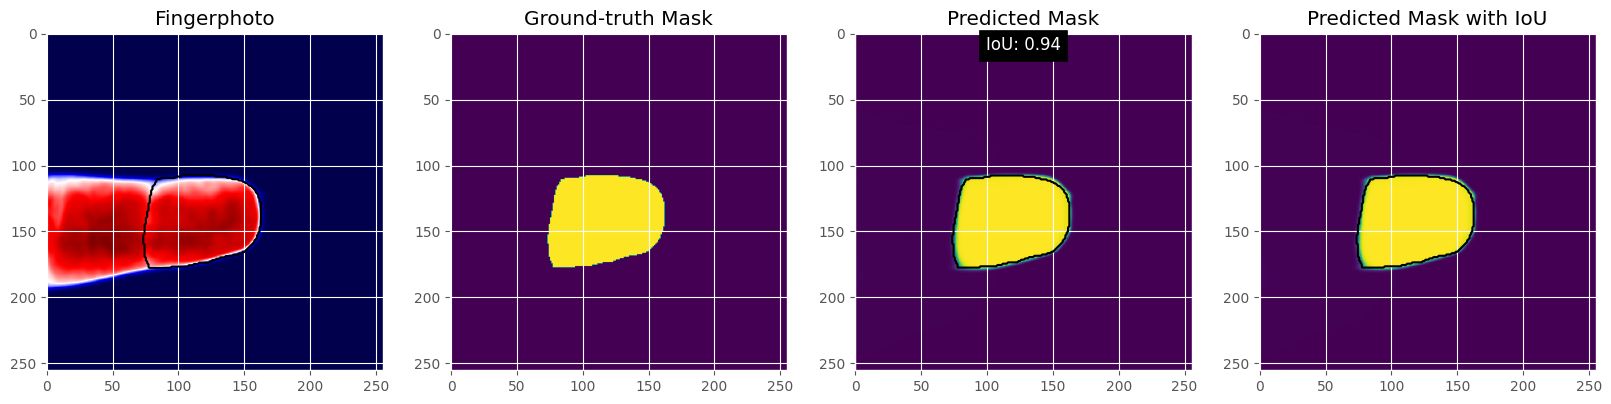

In [65]:
# Check if test data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=10)

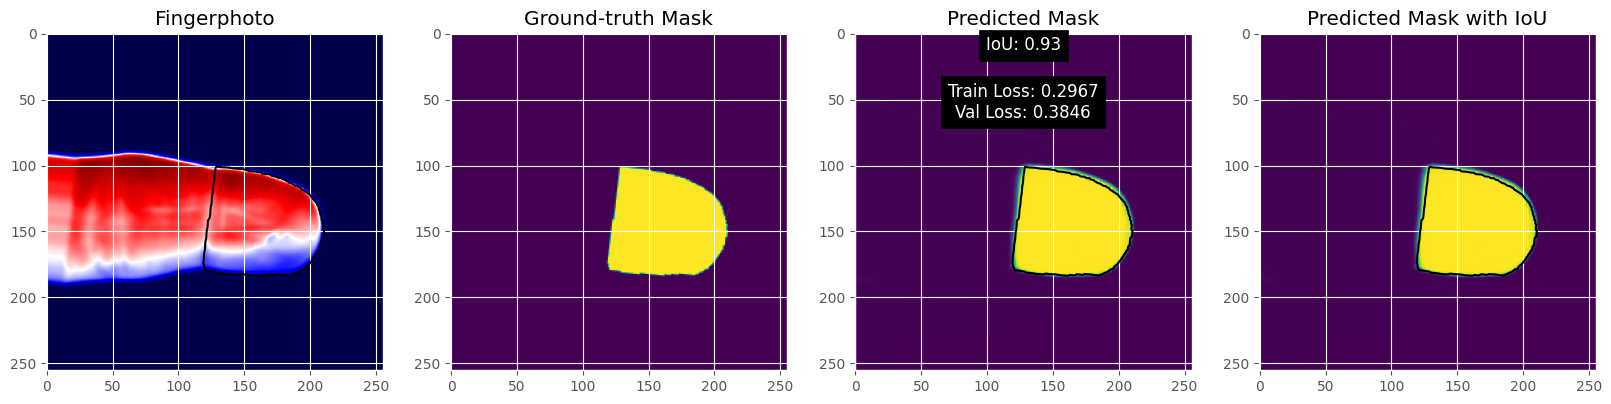

In [66]:
i=1
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

In [57]:
i=52
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

IndexError: list index out of range

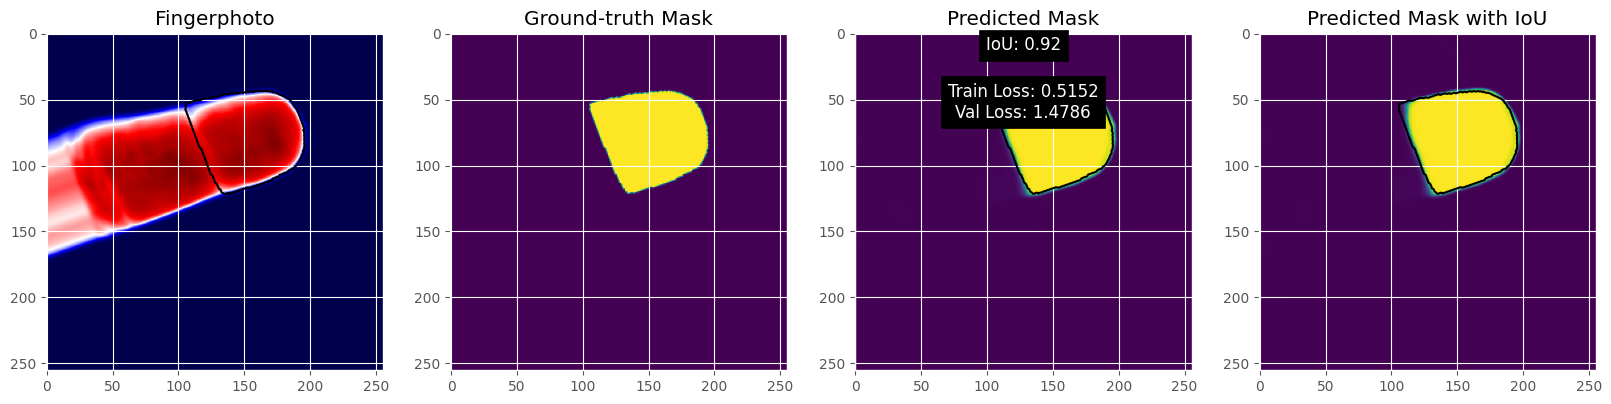

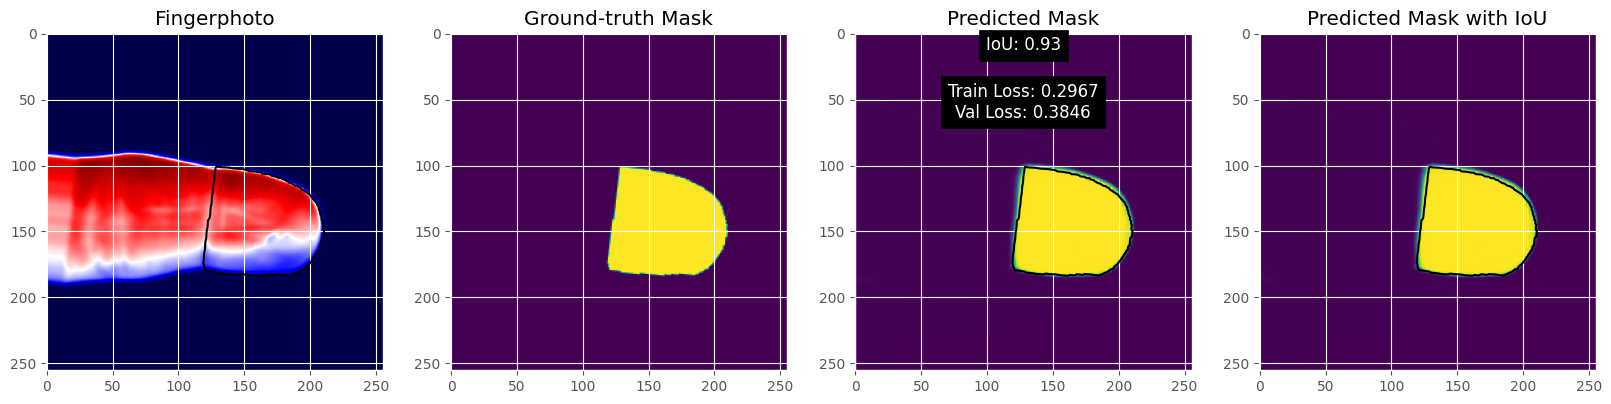

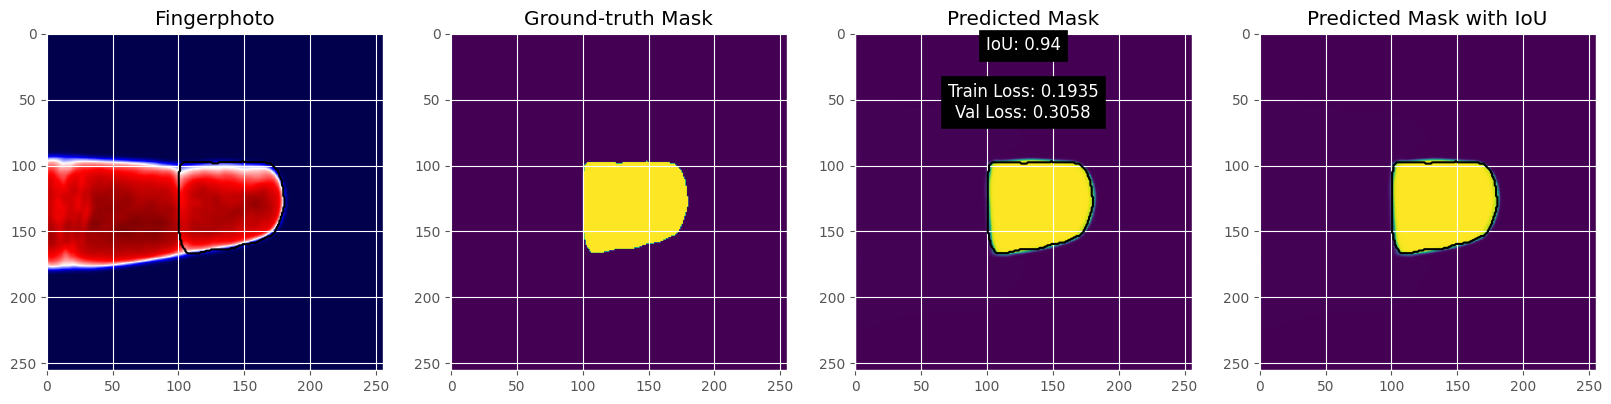

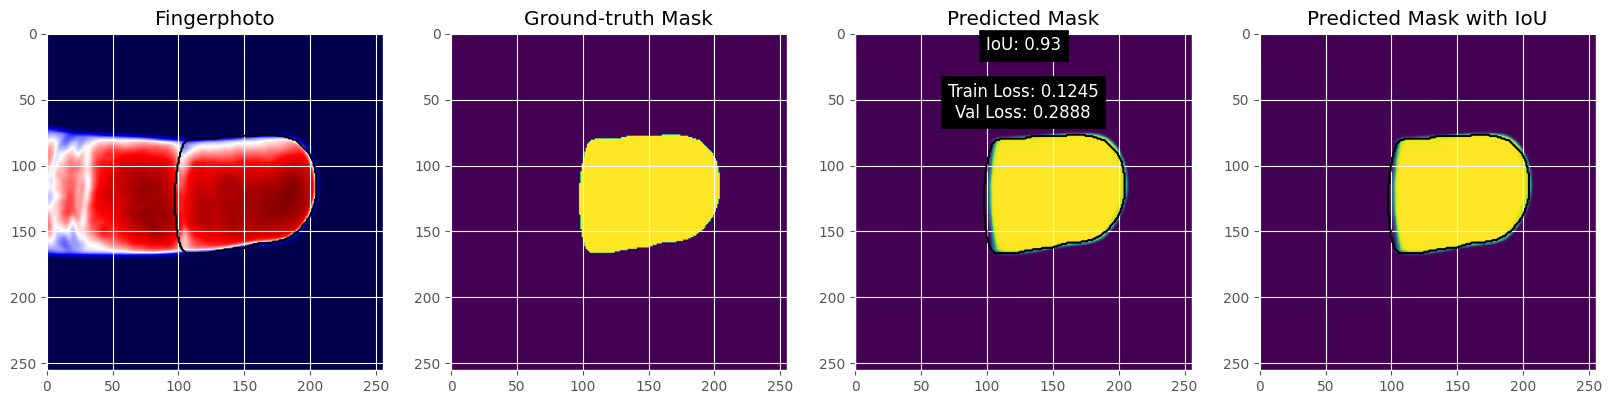

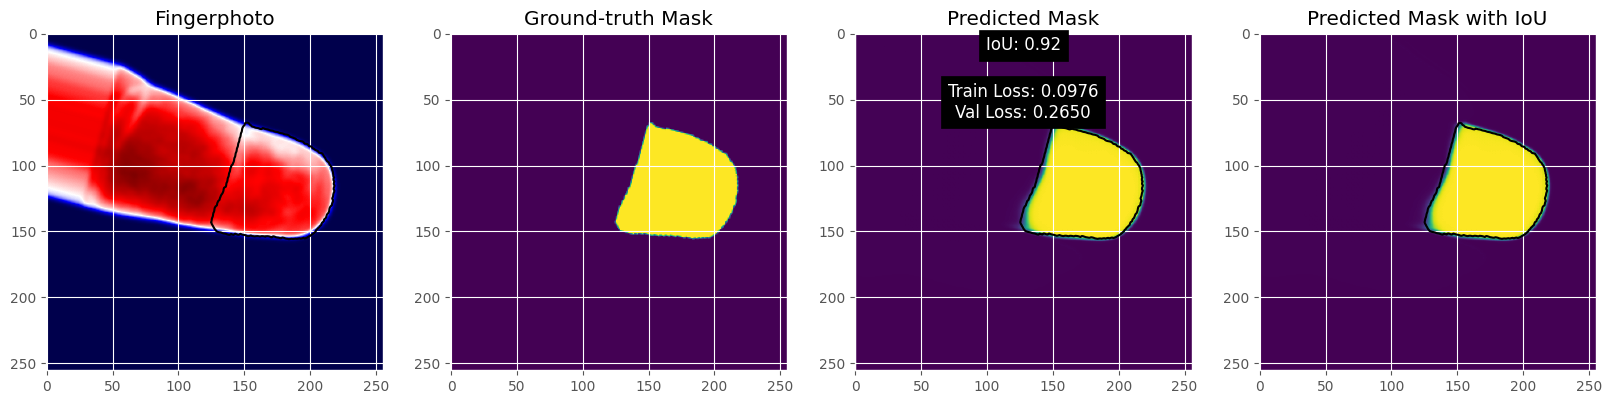

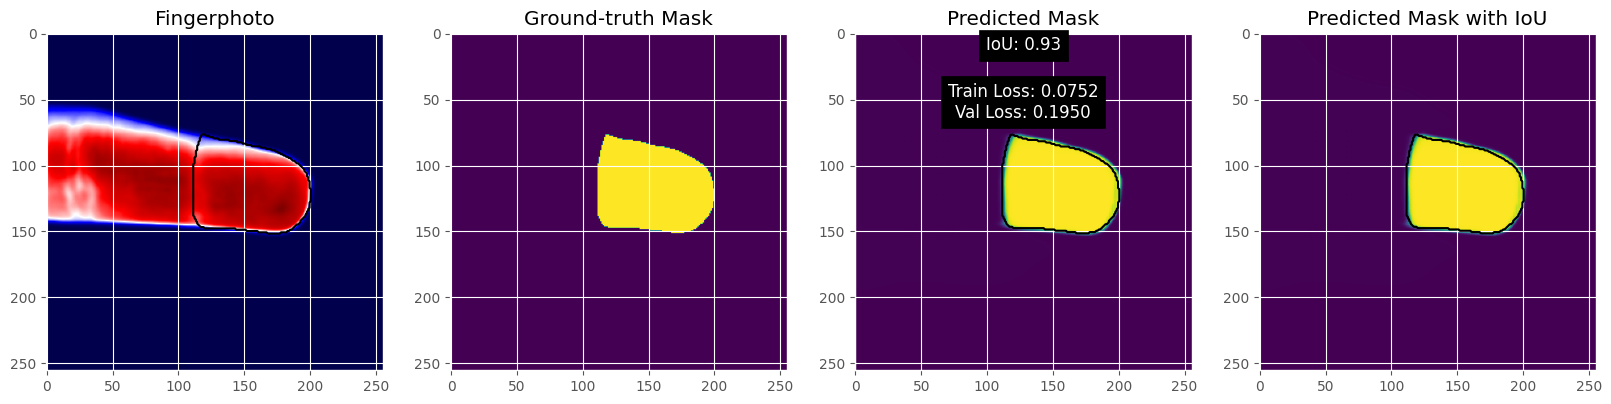

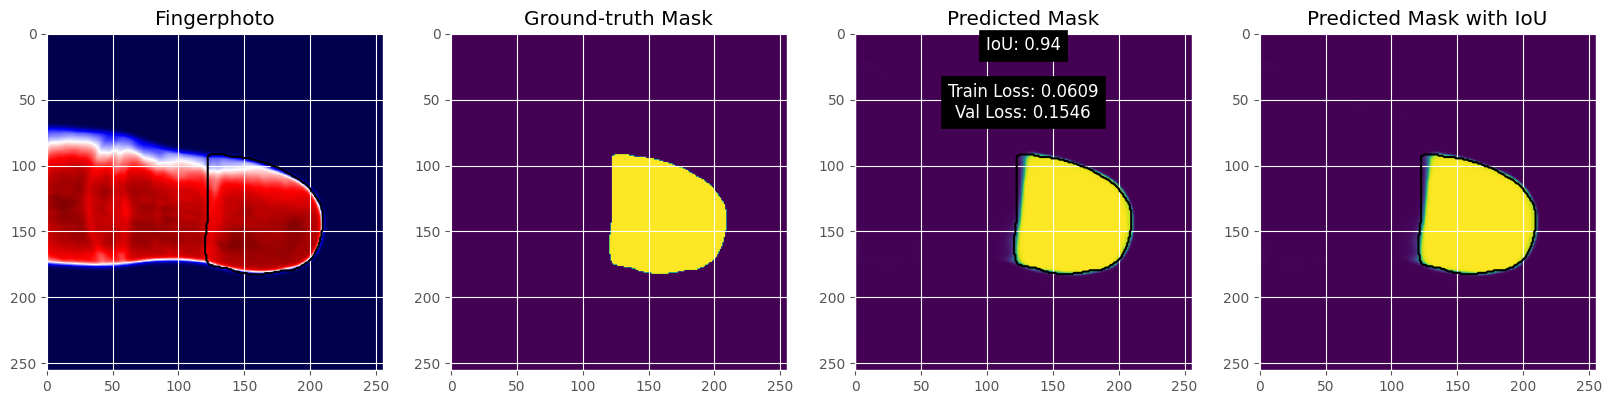

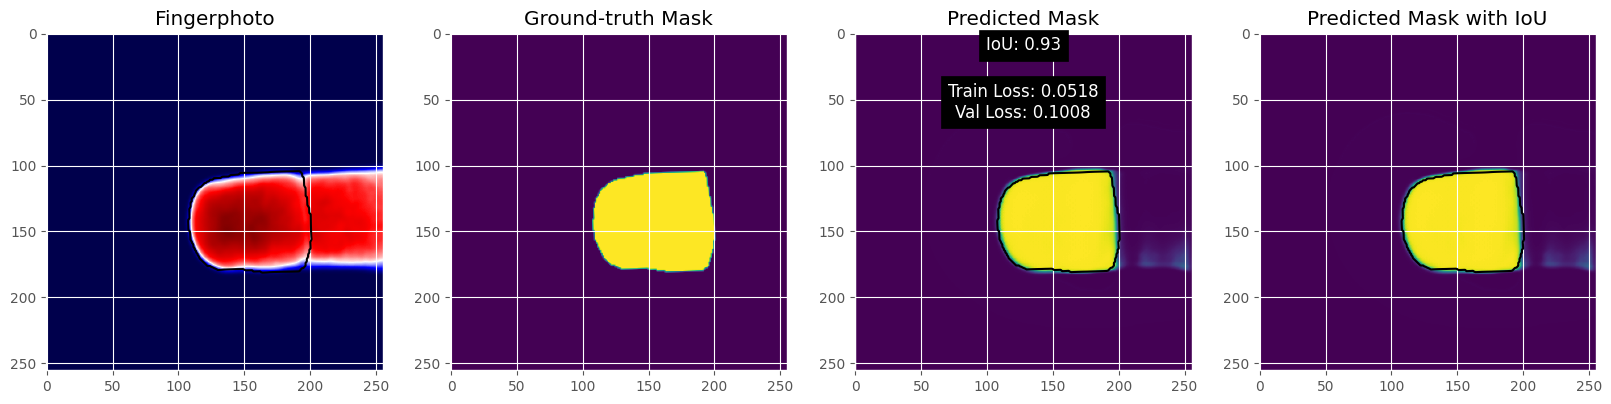

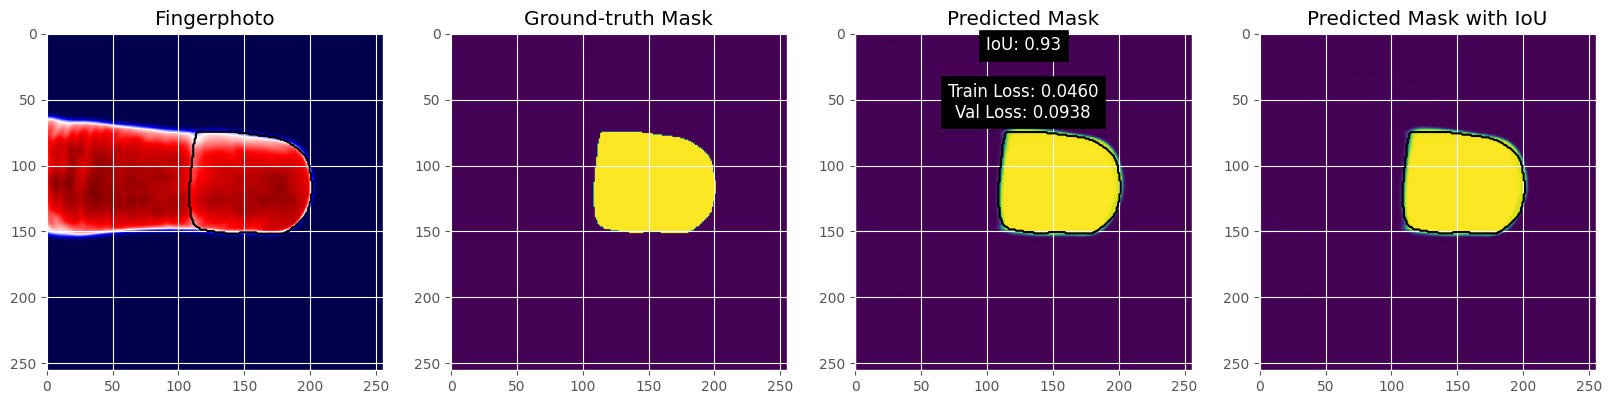

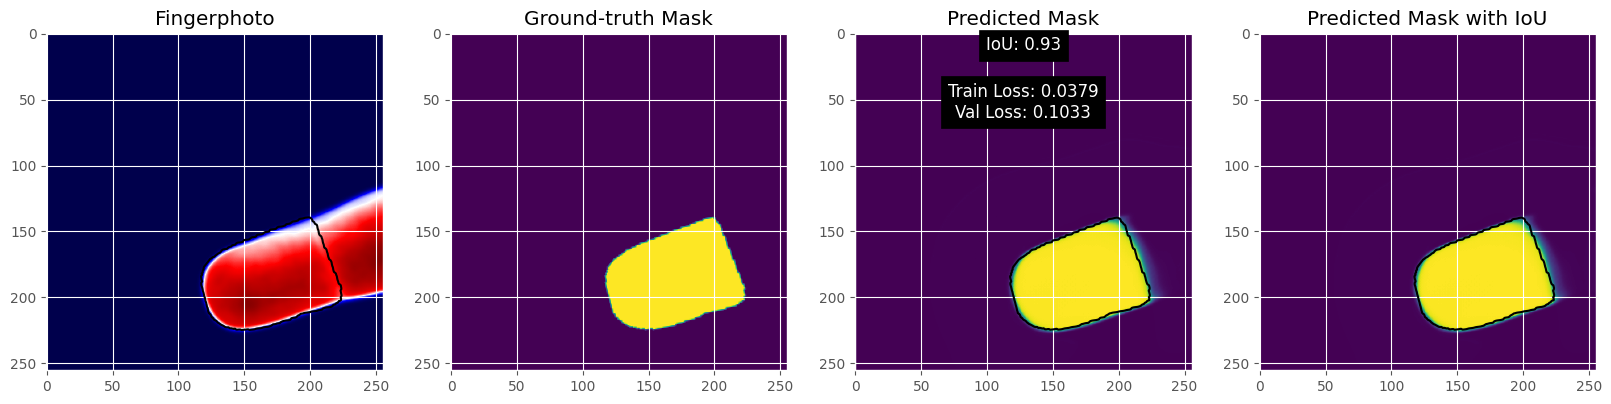

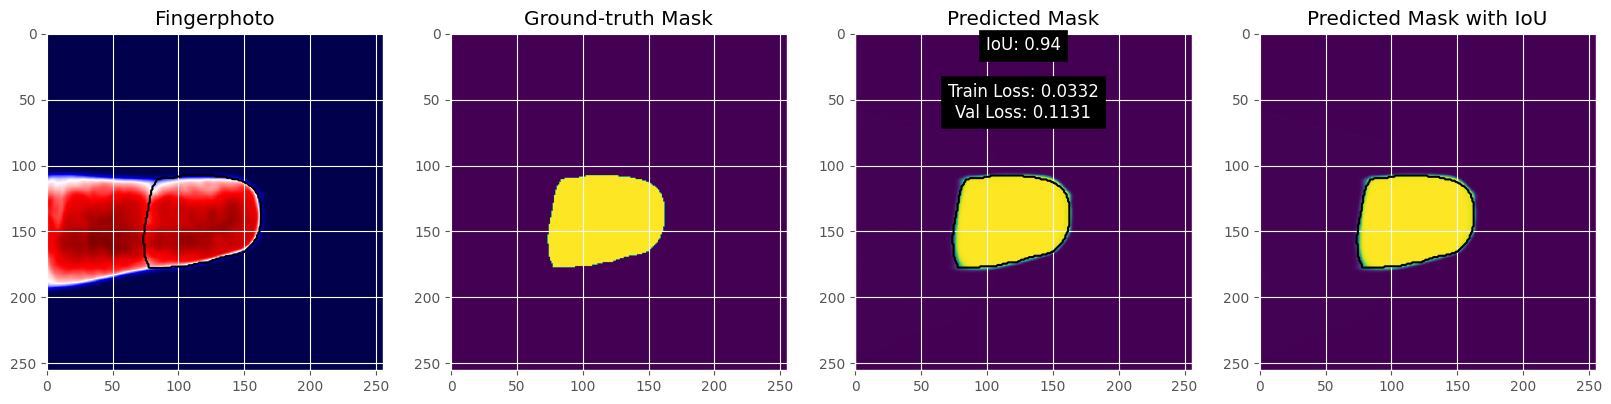

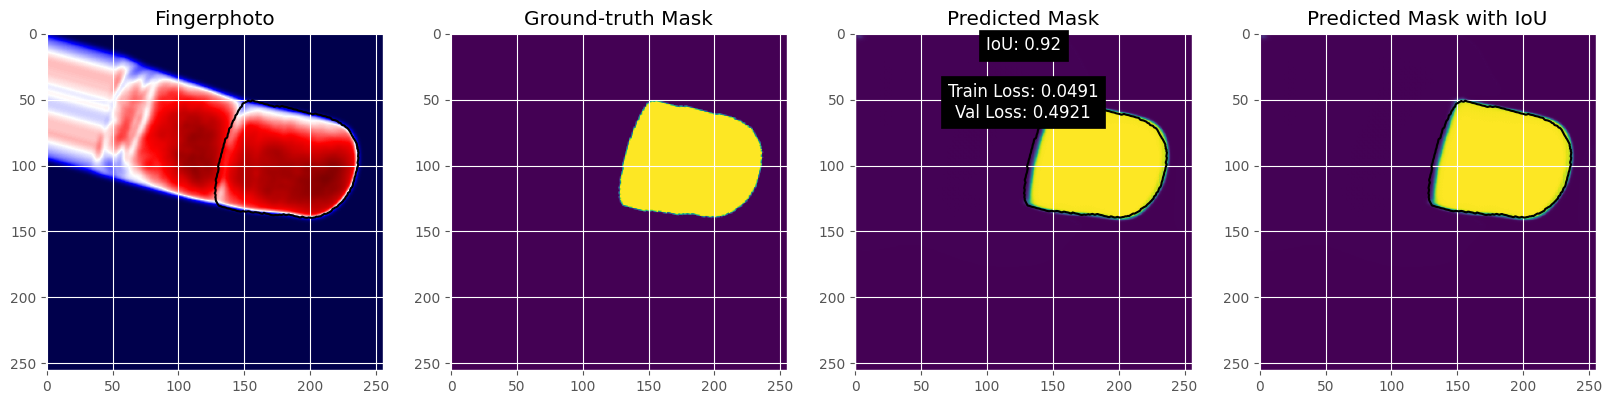

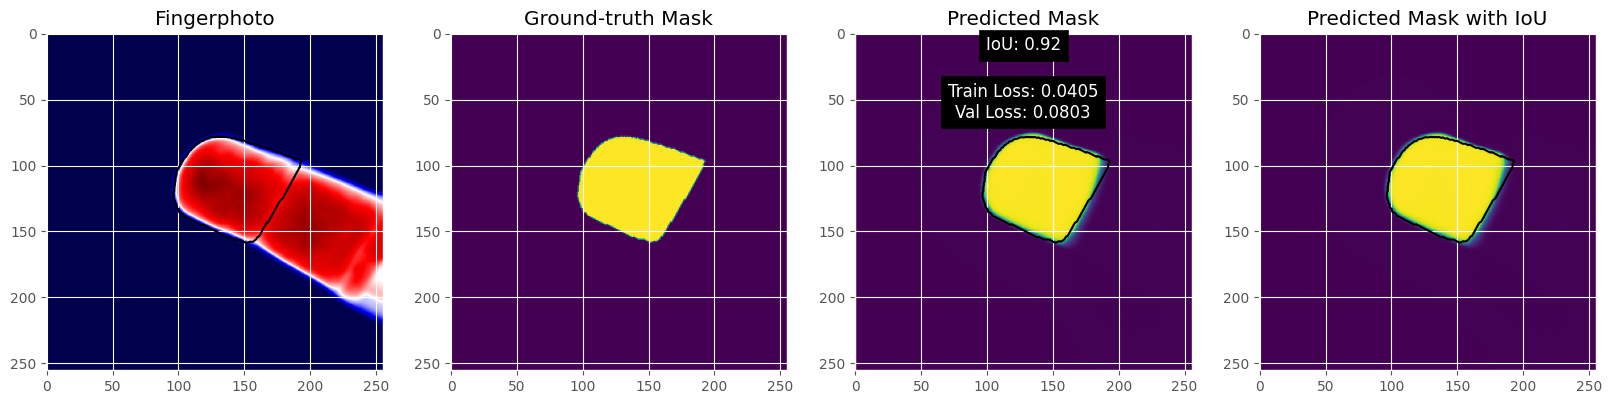

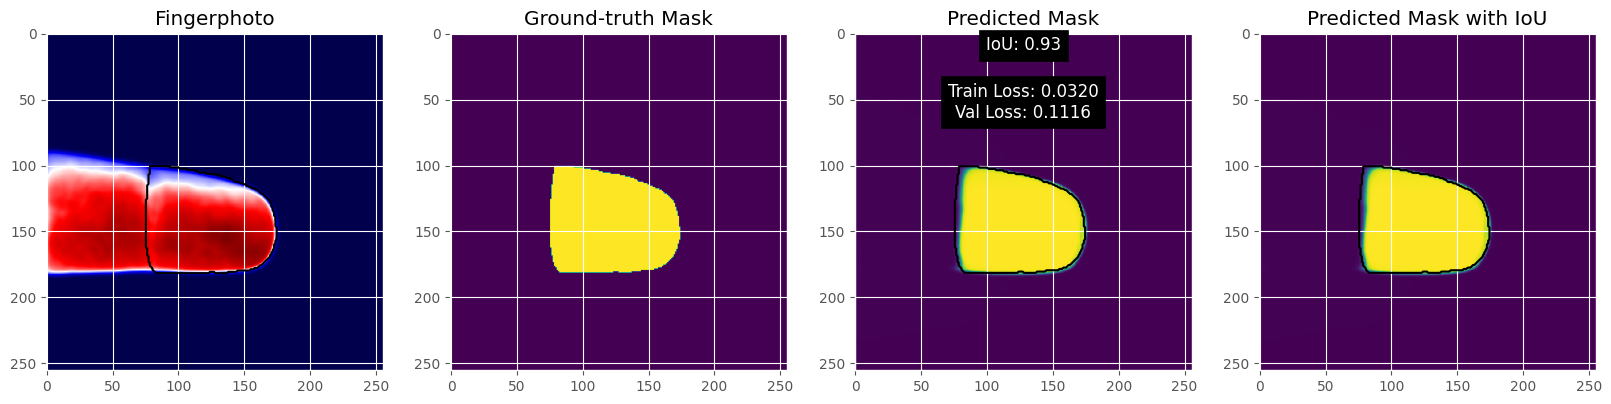

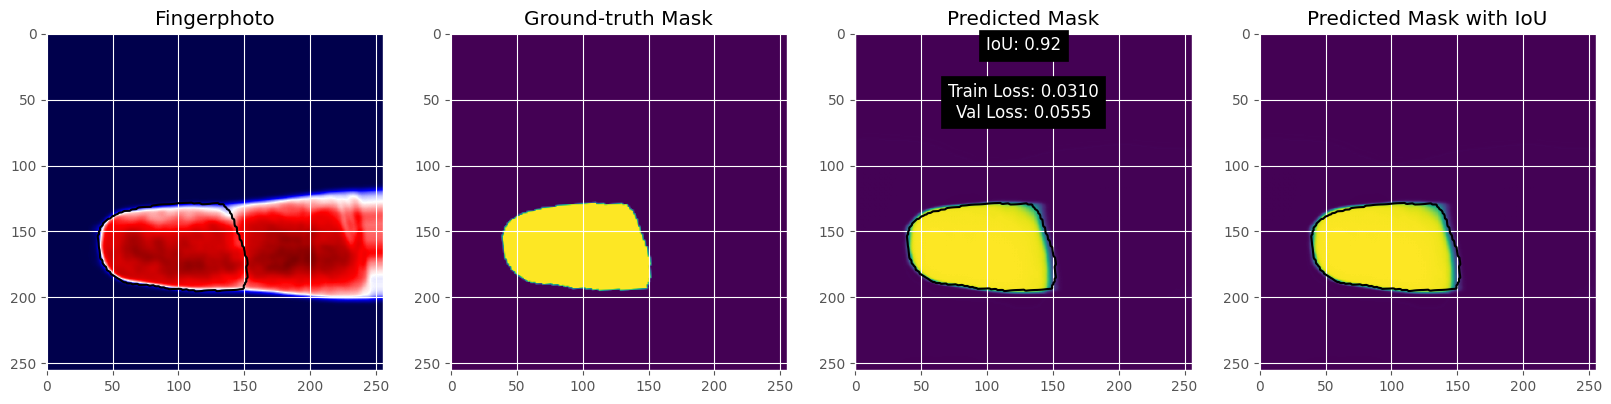

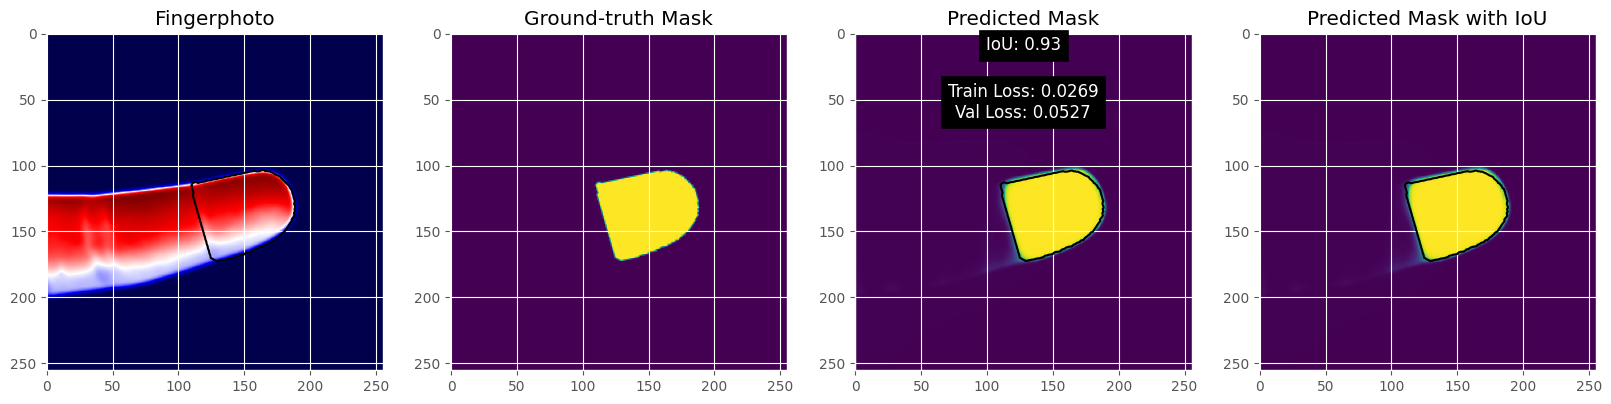

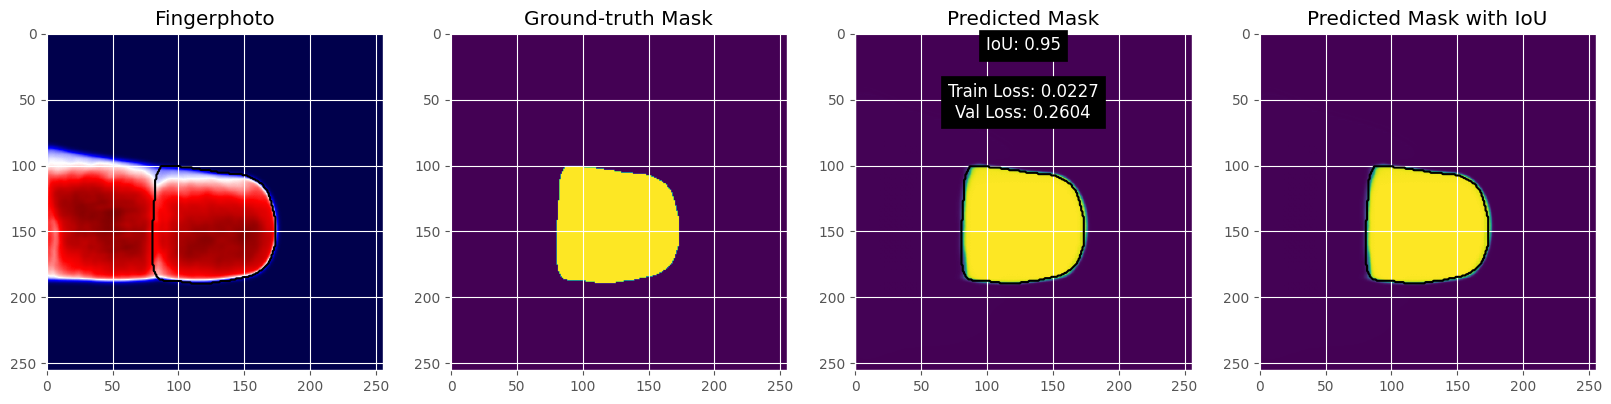

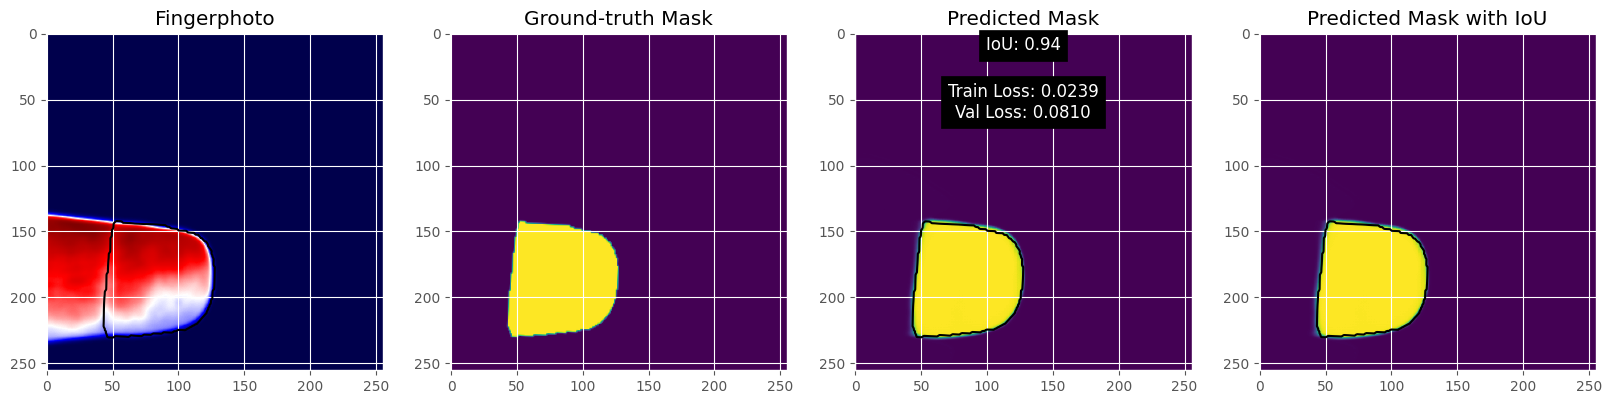

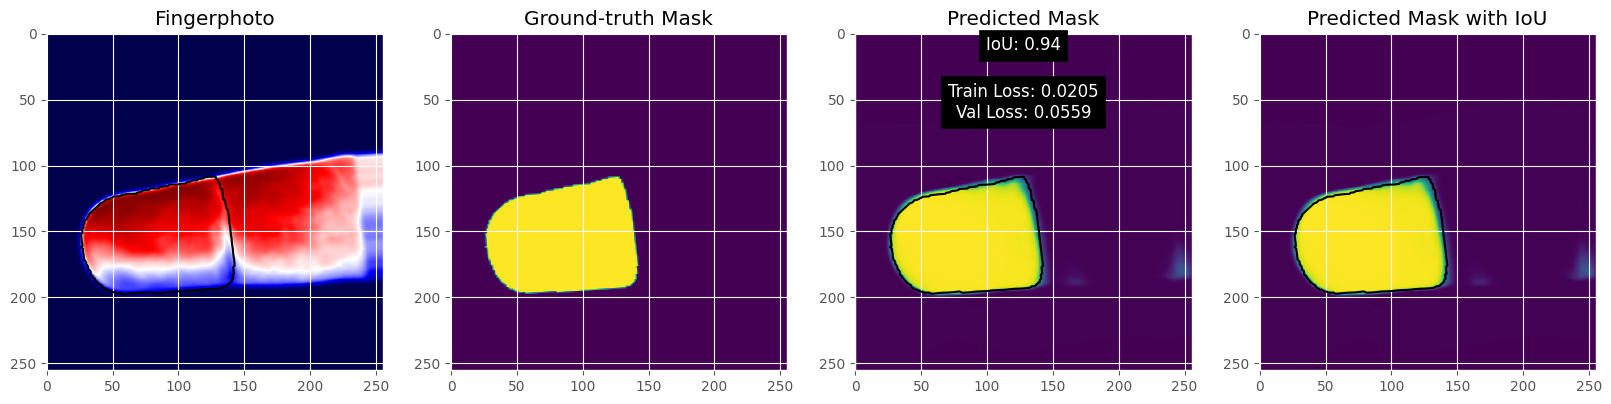

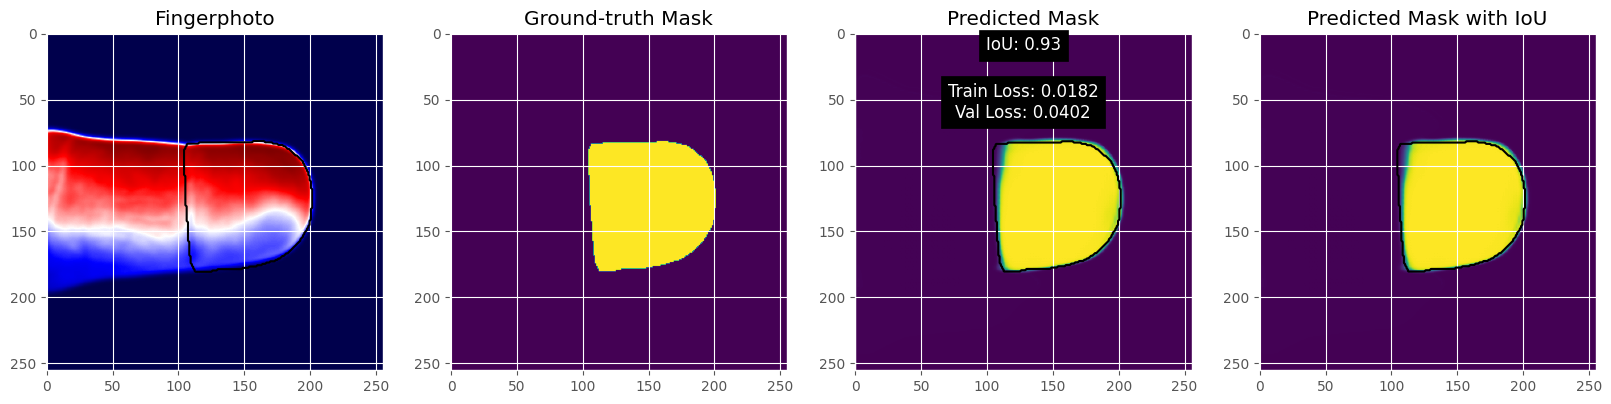

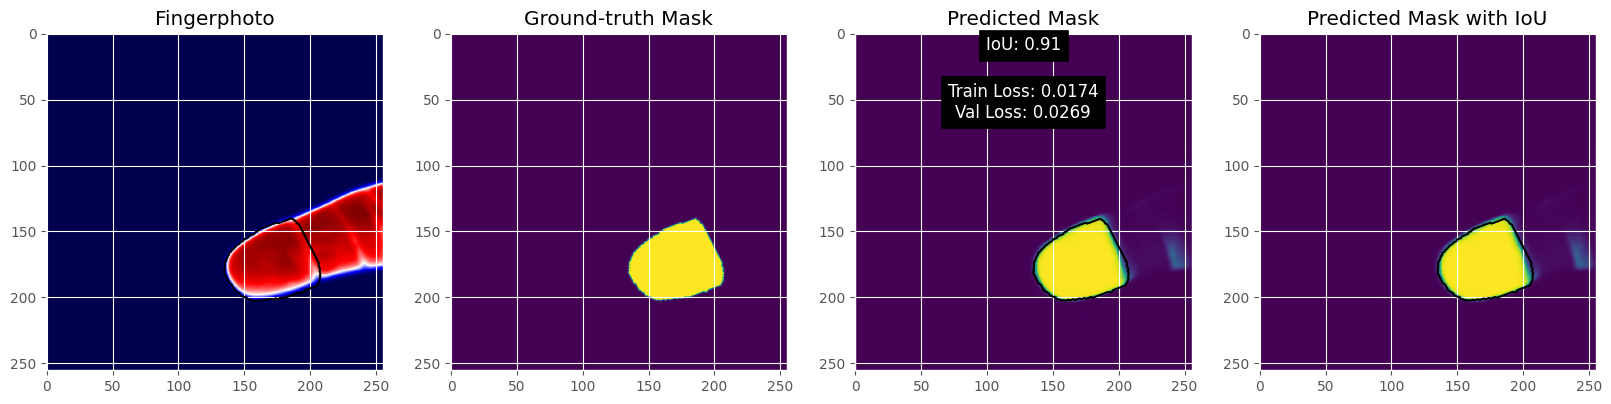

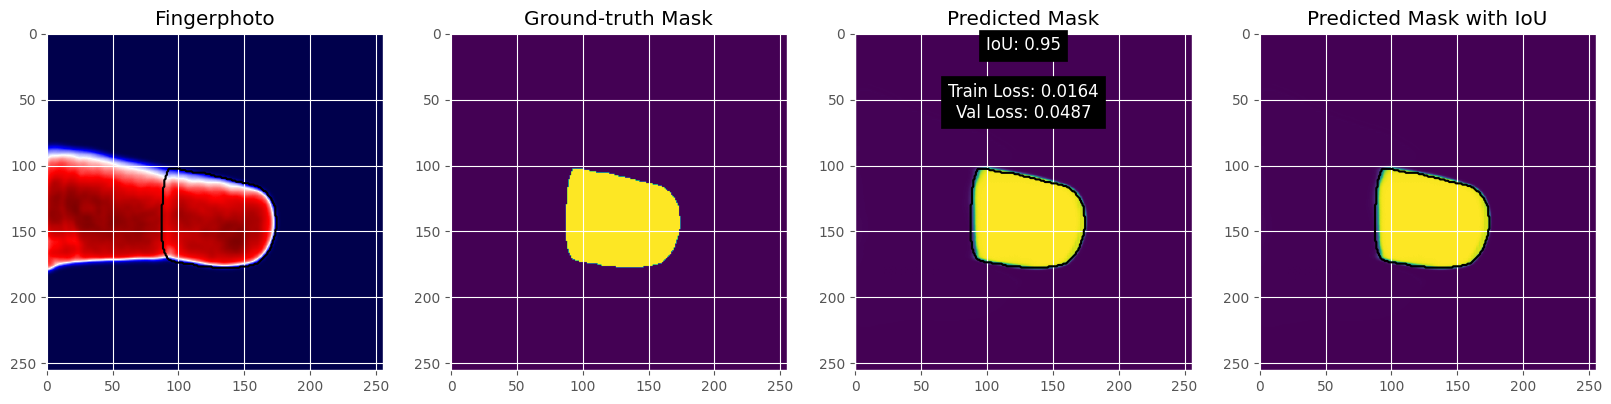

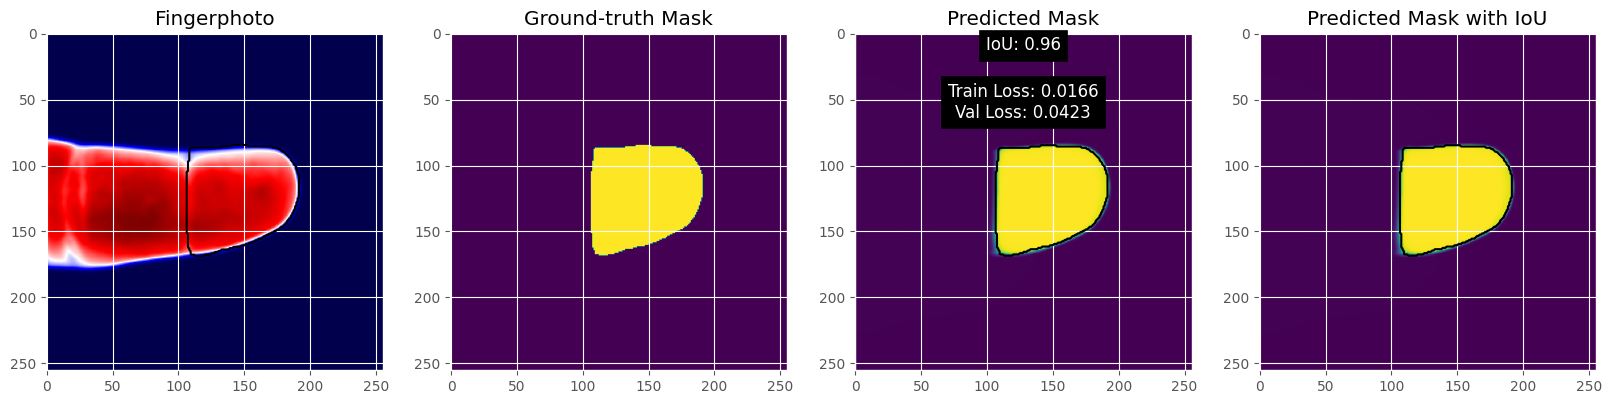

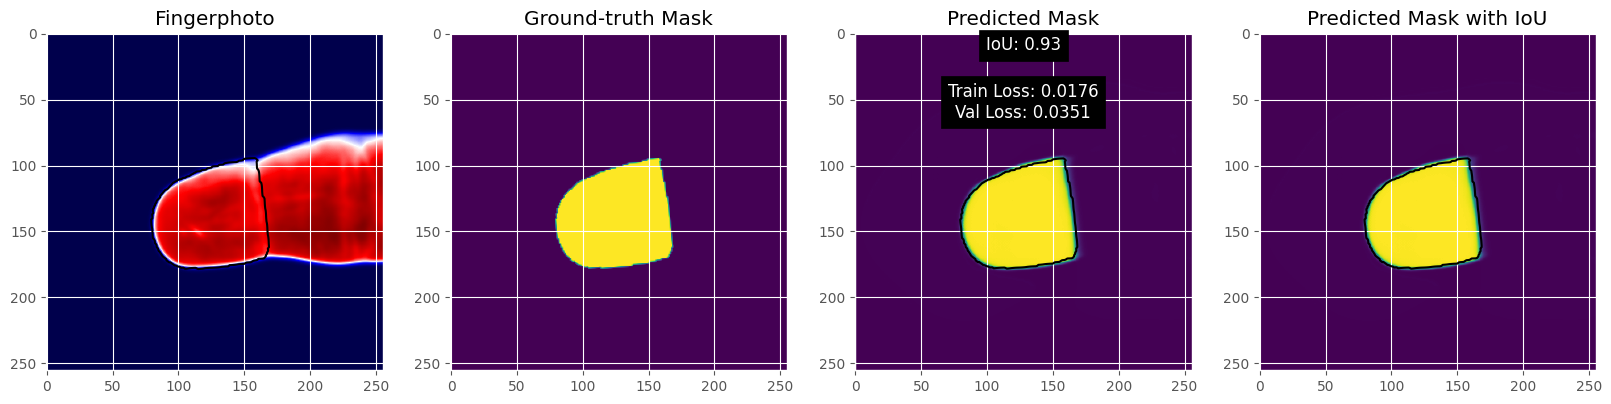

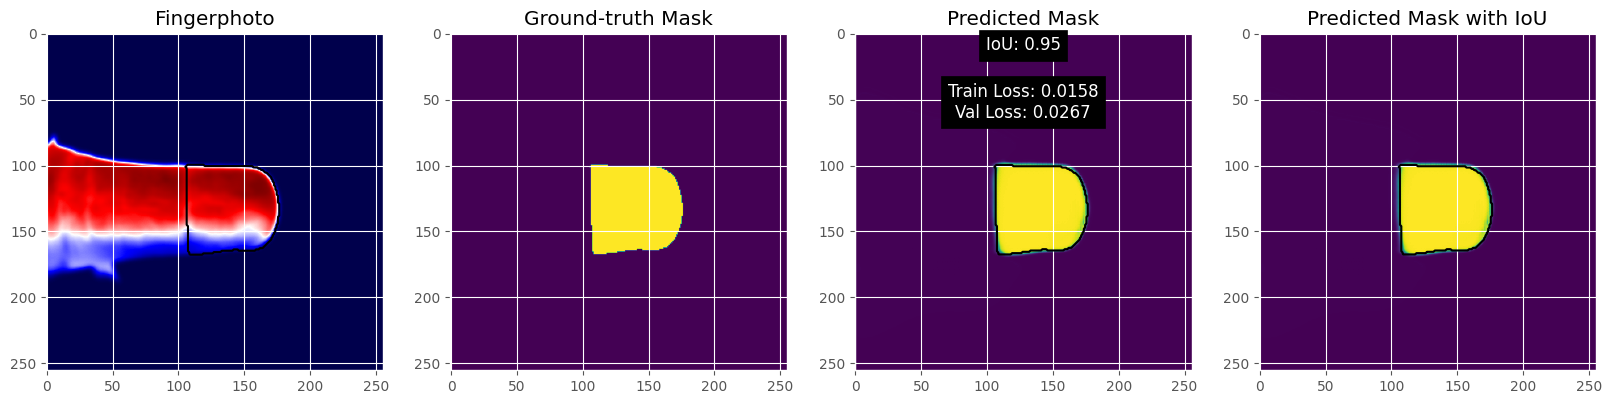

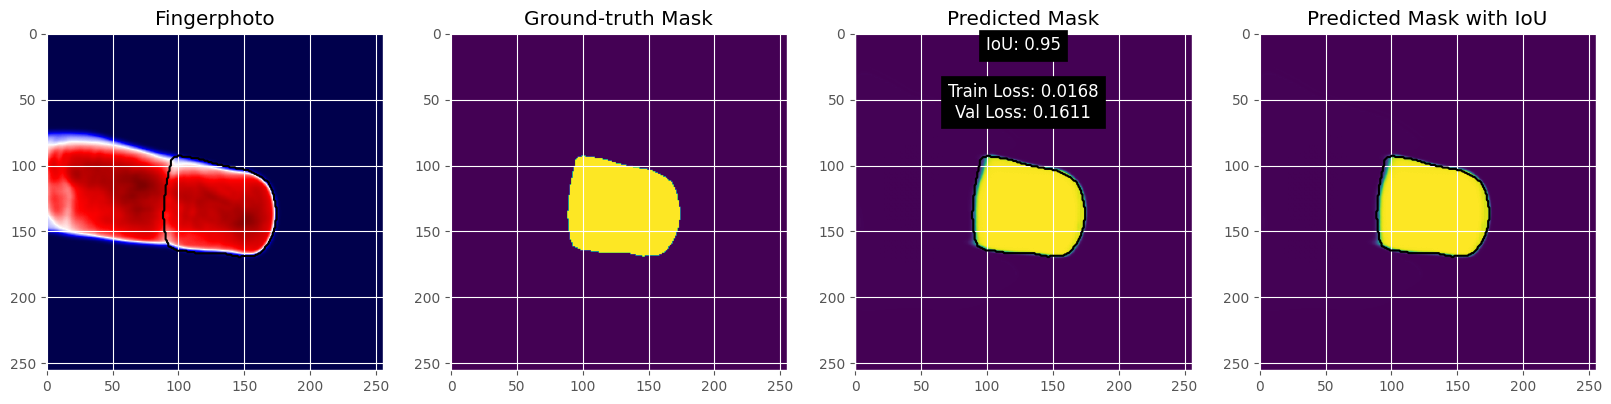

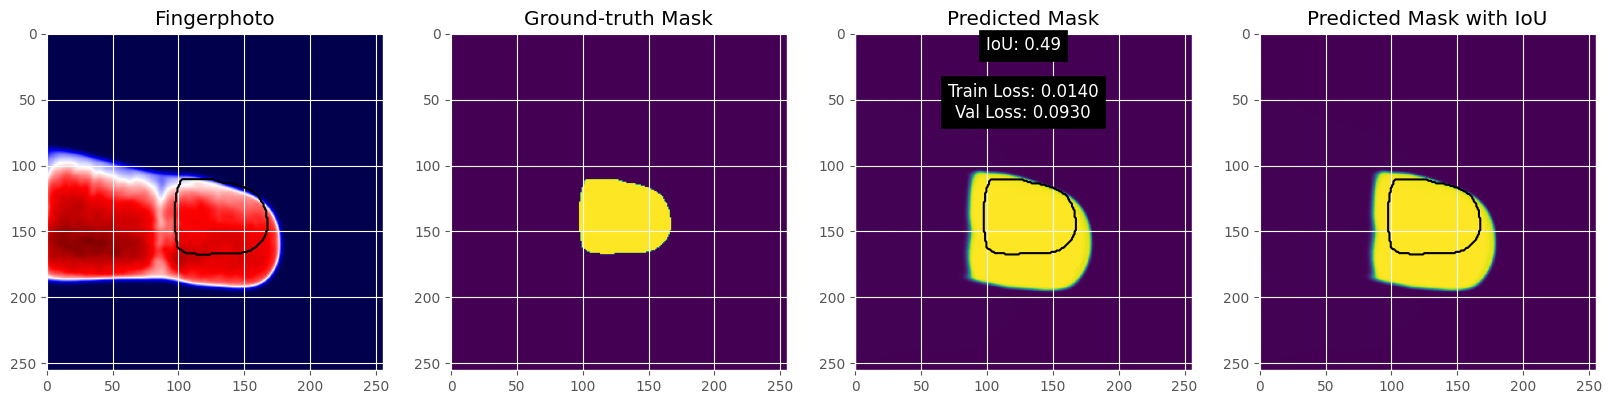

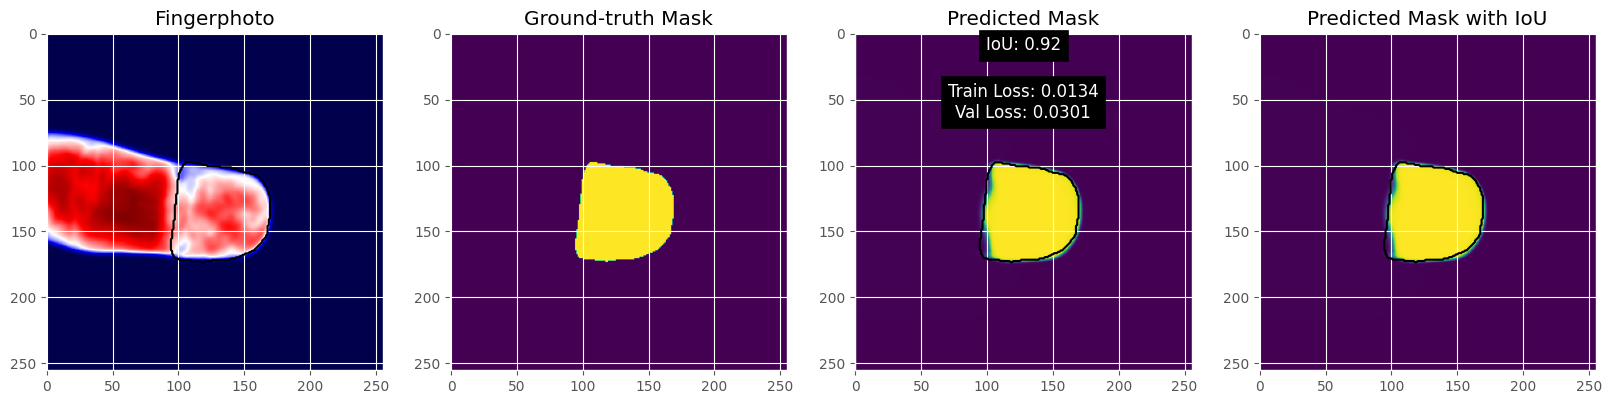

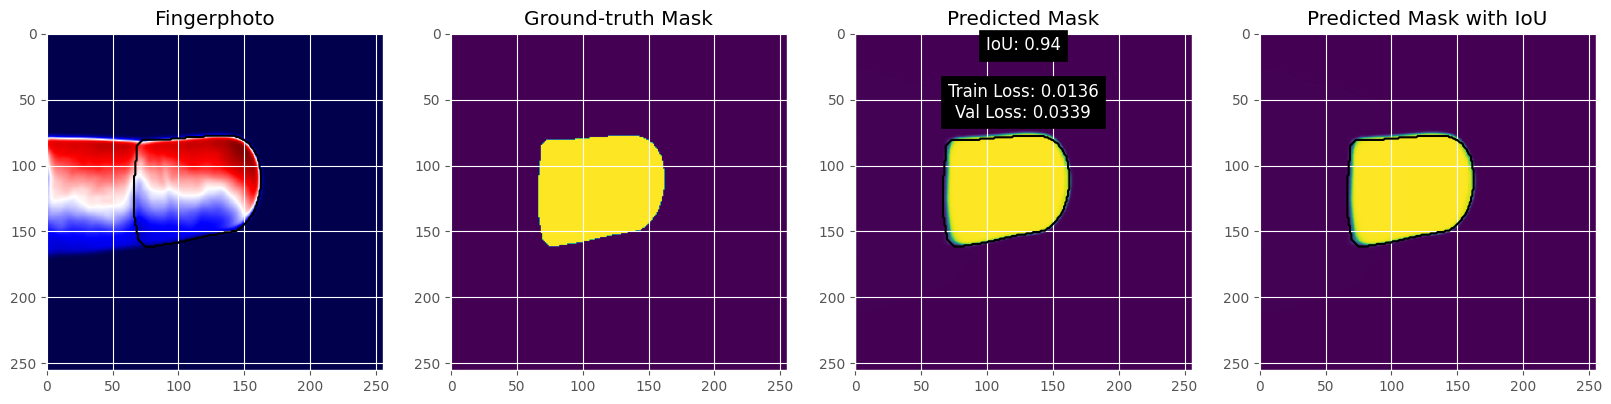

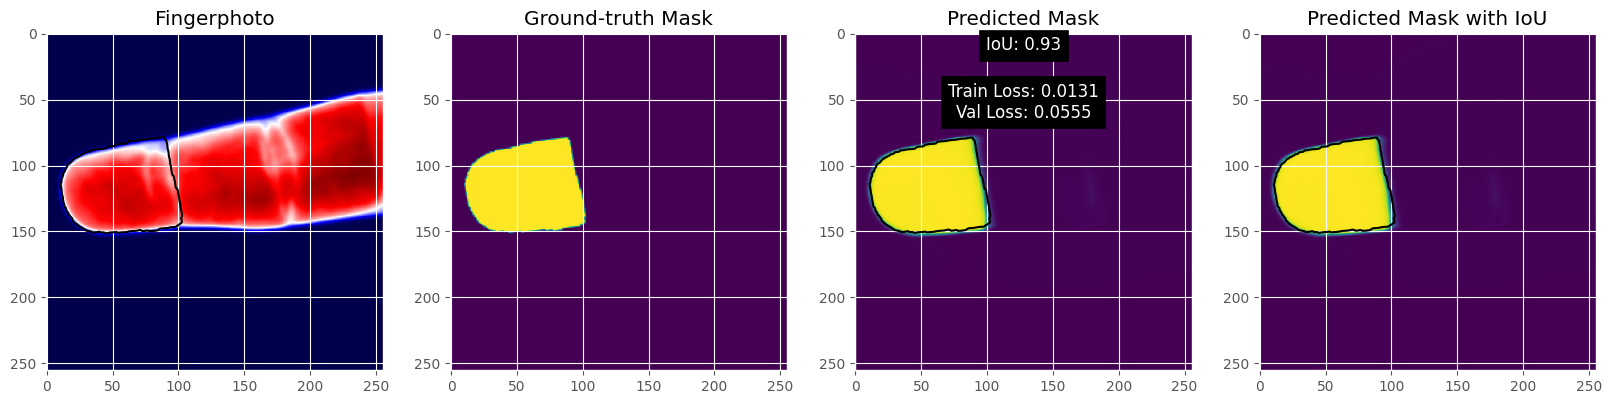

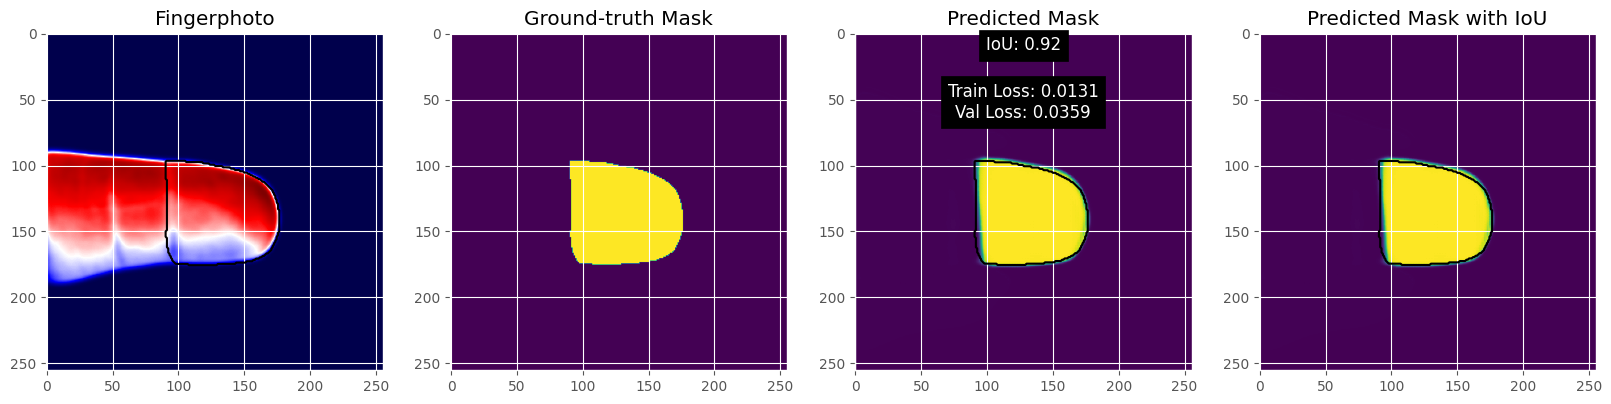

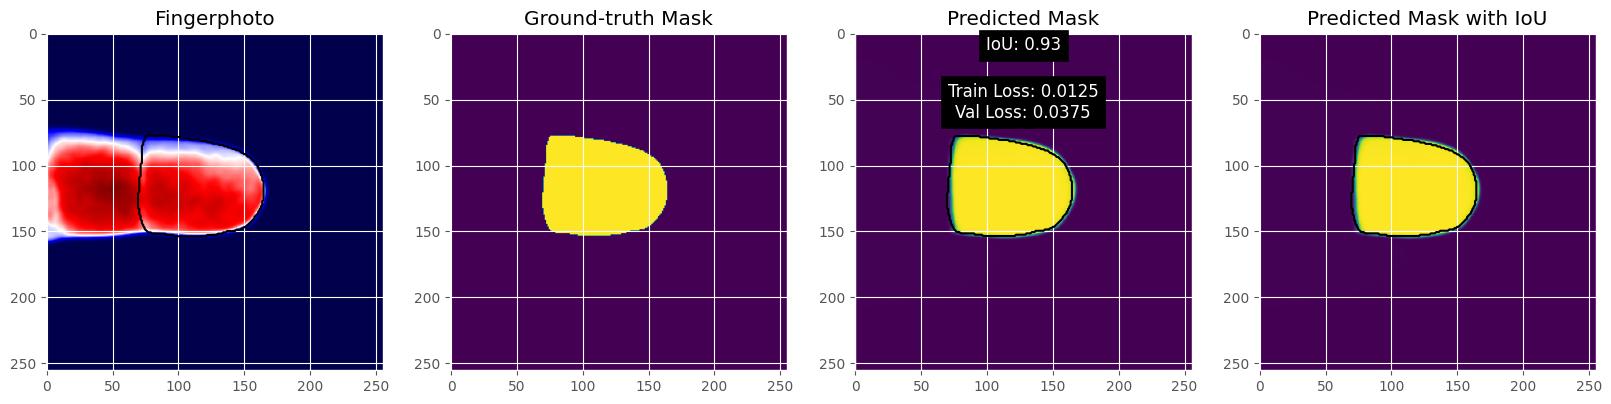

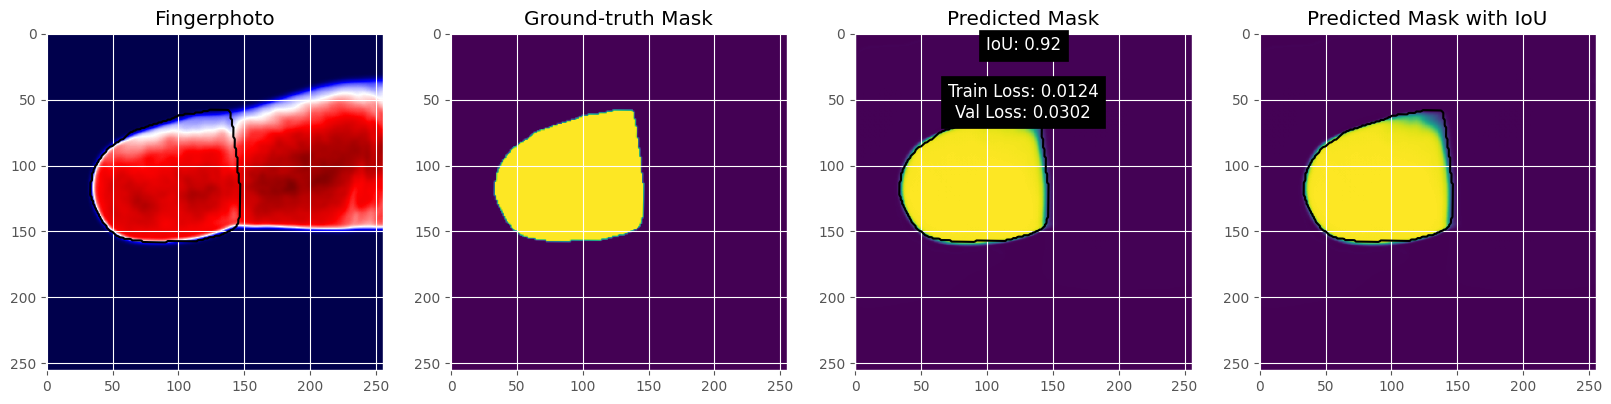

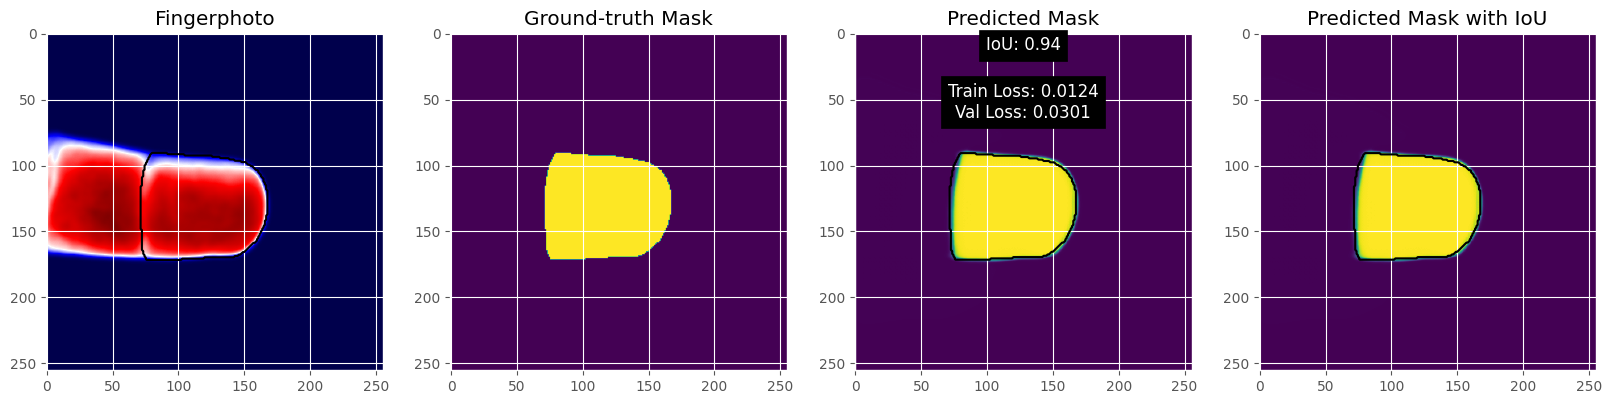

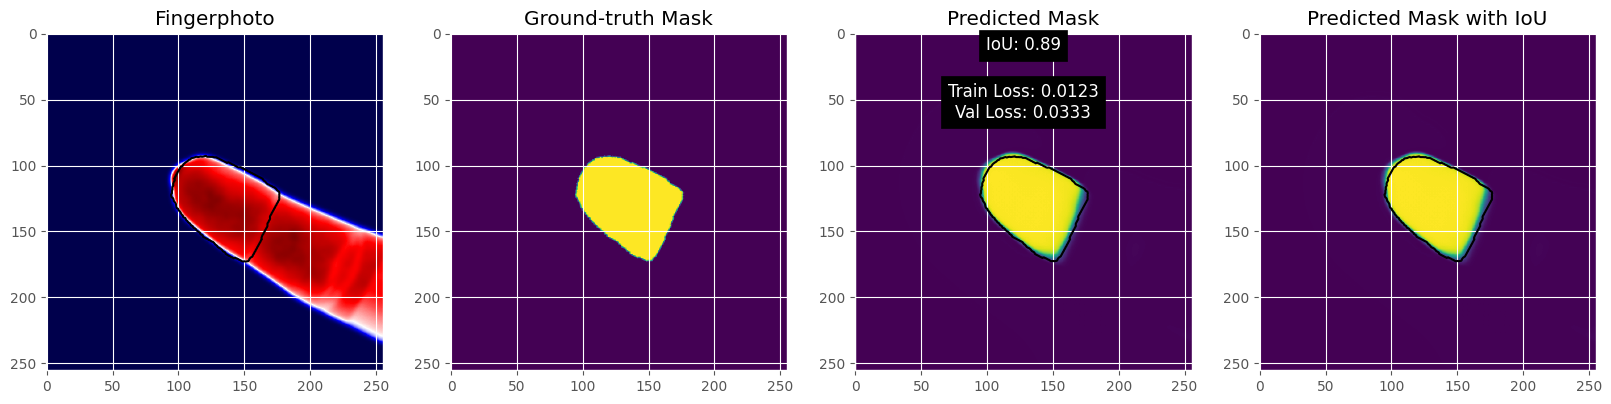

IndexError: list index out of range

In [67]:
for i in range(70):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i, train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])
    plt.show()

In [68]:
i=43
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

IndexError: list index out of range

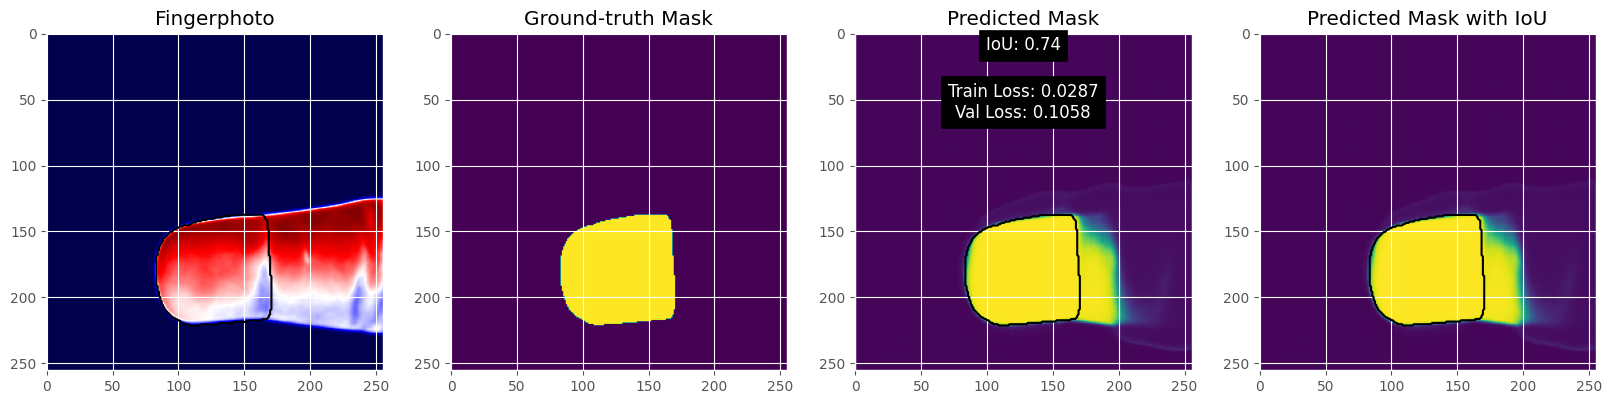

In [85]:
i=45
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

In [69]:
i=35
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

IndexError: list index out of range

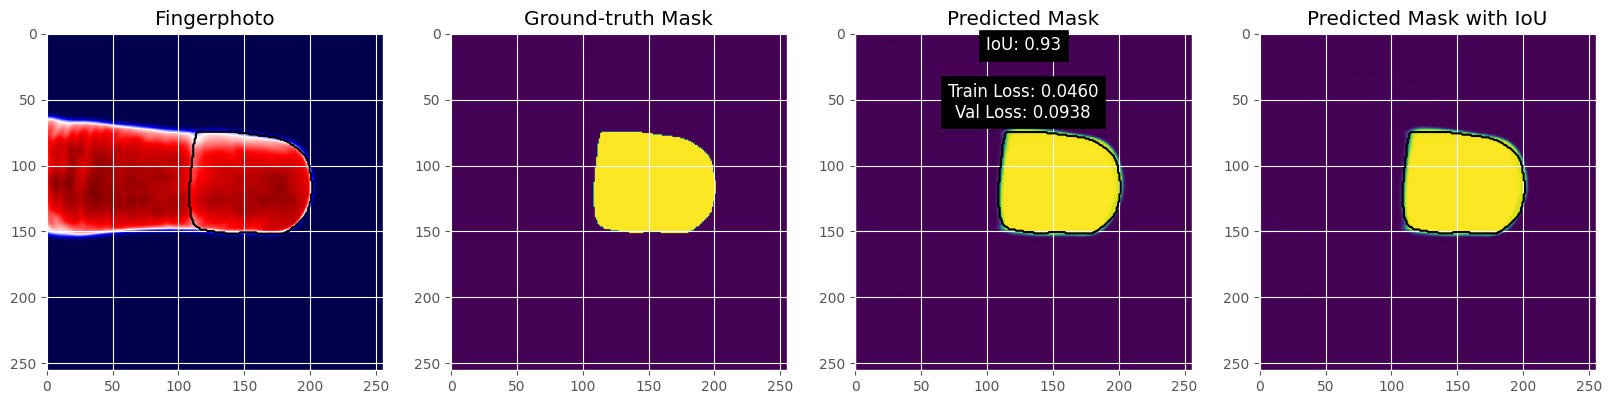

In [72]:
i=8
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

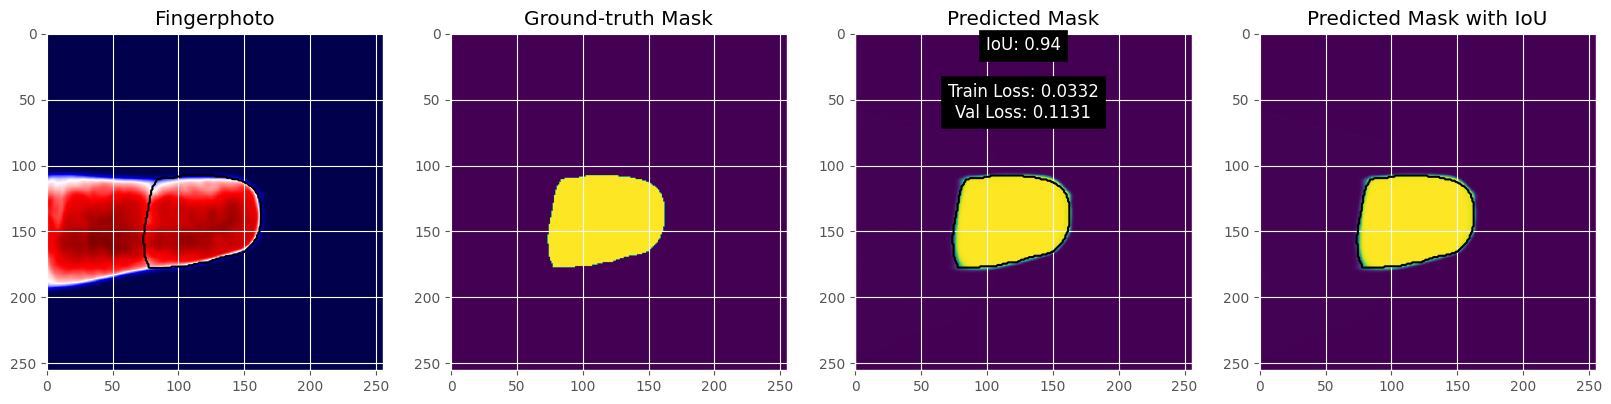

In [74]:
i=10
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

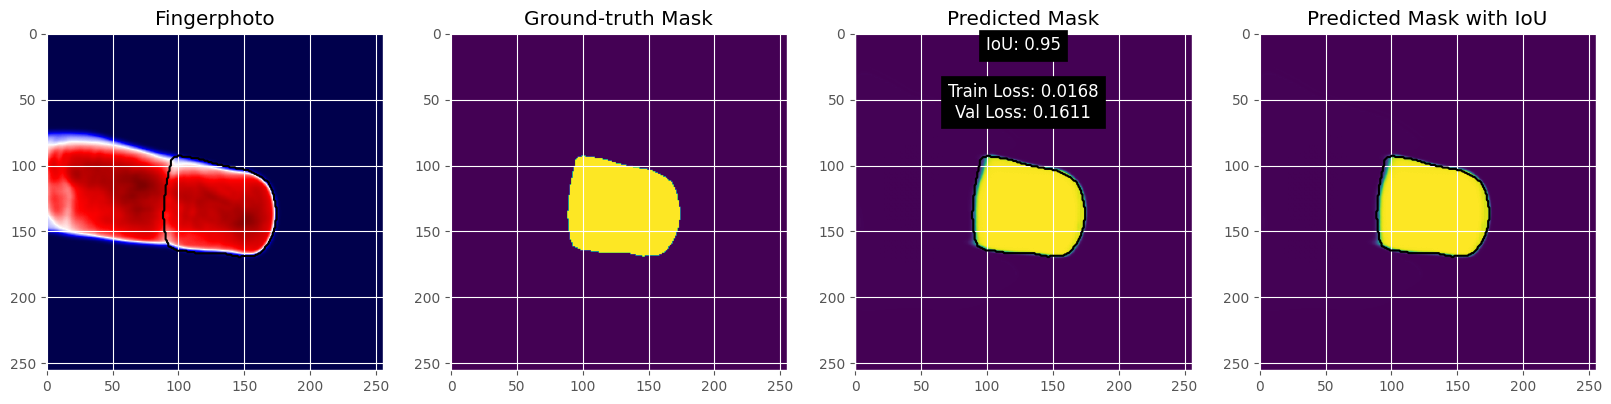

In [77]:
i=25
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

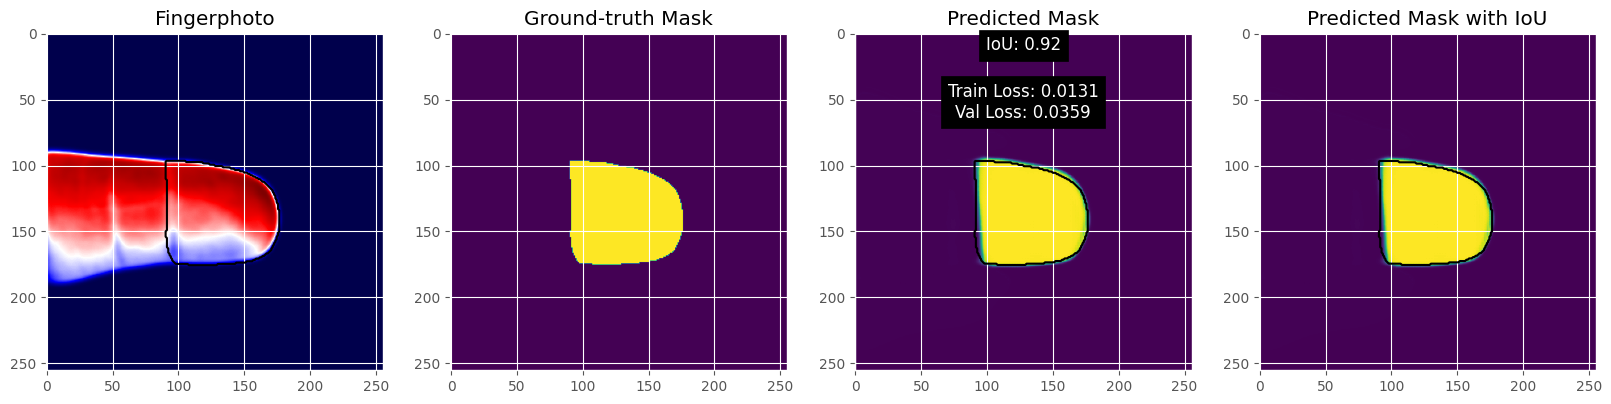

In [78]:
i=30
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])

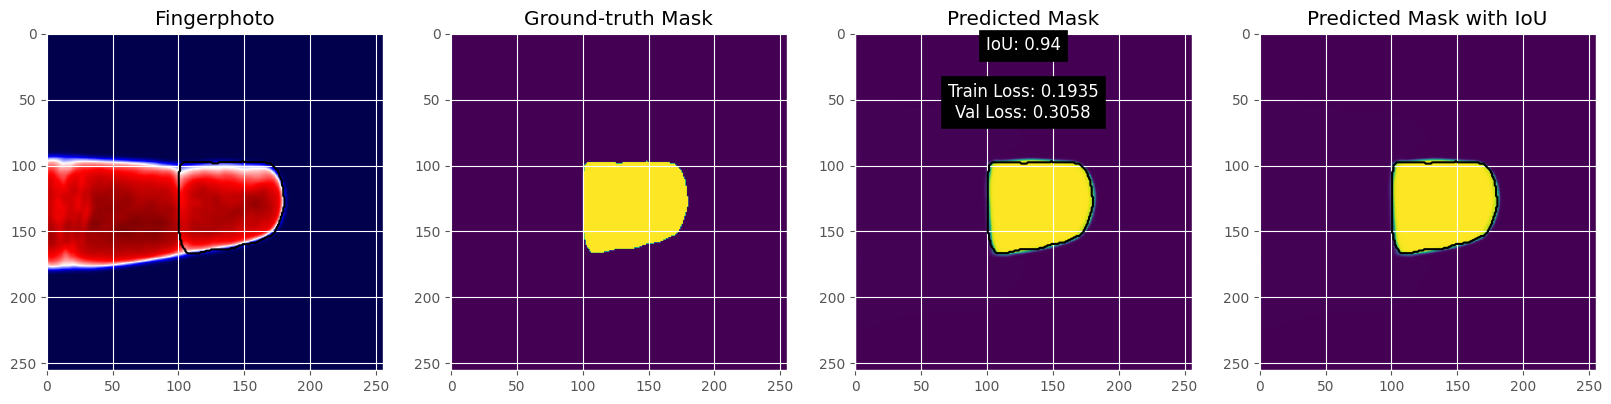

In [82]:
i=2
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i,train_loss=results.history["loss"][i], val_loss=results.history["val_loss"][i])